# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
pandas.options.display.max_columns = None


import workflow
# import workflow.conf
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

/home/ats_sc_user/tinerator/tpls/seacas/install/lib/exodus.py:5269: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if exo.modeChar is 'r':


## Sources and setup

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [3]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
# sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
# sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-08-25 17:31:35,825 - root - INFO: Using sources:
2021-08-25 17:31:35,826 - root - INFO: --------------
2021-08-25 17:31:35,828 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2021-08-25 17:31:35,829 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2021-08-25 17:31:35,830 - root - INFO: DEM: National Elevation Dataset (NED)
2021-08-25 17:31:35,831 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-08-25 17:31:35,831 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-08-25 17:31:35,832 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-08-25 17:31:35,834 - root - INFO: soil thickness: None
2021-08-25 17:31:35,834 - root - INFO: meteorology: DayMet 1km


## Specify watershed

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

**Option 1: Import from shapefile**

This works for customized watershed shape (e.g., a watershed < HUC12).

2021-08-25 17:31:38,261 - root - INFO: 
2021-08-25 17:31:38,263 - root - INFO: Meshing shape: ../../watershed-workflow/data/hydrologic_units/others/Coweeta/coweeta_basin.shp
2021-08-25 17:31:38,264 - root - INFO: ==============================
2021-08-25 17:31:38,265 - root - INFO: 
2021-08-25 17:31:38,266 - root - INFO: Loading shapes
2021-08-25 17:31:38,267 - root - INFO: ------------------------------
2021-08-25 17:31:38,267 - root - INFO: Loading file: '../../watershed-workflow/data/hydrologic_units/others/Coweeta/coweeta_basin.shp'
2021-08-25 17:31:38,306 - root - INFO: ... found 1 shapes
2021-08-25 17:31:38,307 - root - INFO: Converting to shapely


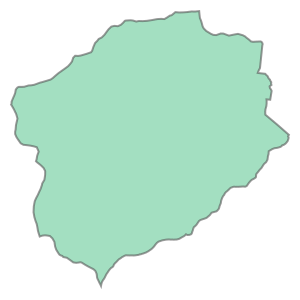

In [4]:
# specify the input shapefile and a hint as to what HUC it is in.
coweeta_shapefile = '../../watershed-workflow/data/hydrologic_units/others/Coweeta/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(coweeta_shapefile)

watershed.exterior()

**Option 2: Import from HUC**

This works better for standard HUC shape (i.e. HUC12 and above).

In [24]:
# hucs = ['060102020103'] # Coweeta Creek and Litter Tennessee River
# # crs = workflow.crs.daymet_crs()
# crs = workflow.crs.from_epsg("26917")

# # load the hucs
# my_hucs = []

# for huc in hucs:
#     _, watersheds = workflow.get_hucs(sources['HUC'], huc, level = len(huc), out_crs = crs)
#     assert(len(watersheds) == 1)
#     my_hucs.extend(watersheds)
# watershed = workflow.split_hucs.SplitHUCs(my_hucs)

# watershed.exterior()

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Find HUC 

In [5]:
# find what HUC our shape is in
huc = '060102020103' # provide the huc if known
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint, shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [6]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, snap=True,
                                         cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)

2021-08-25 17:31:50,766 - root - INFO: 
2021-08-25 17:31:50,768 - root - INFO: Loading Hydrography
2021-08-25 17:31:50,768 - root - INFO: ------------------------------
2021-08-25 17:31:50,769 - root - INFO: Loading streams in HUC 060102020103
2021-08-25 17:31:50,769 - root - INFO:          and/or bounds (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2021-08-25 17:31:50,777 - root - INFO:   Using Hydrography file "/home/ats_sc_user/short-course/02_model_setup/data/hydrography/NHD_H_06010202_GDB/NHD_H_06010202.gdb"
2021-08-25 17:31:50,778 - root - INFO:   National Hydrography Dataset (NHD): opening '/home/ats_sc_user/short-course/02_model_setup/data/hydrography/NHD_H_06010202_GDB/NHD_H_06010202.gdb' layer 'NHDFlowline' for streams in '(273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)'
2021-08-25 17:31:52,336 - root - INFO:   Filtering reaches not in-network
2021-08-25 17:31:52,339 - root - INFO: ... found 35 reaches
2021-08-25

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


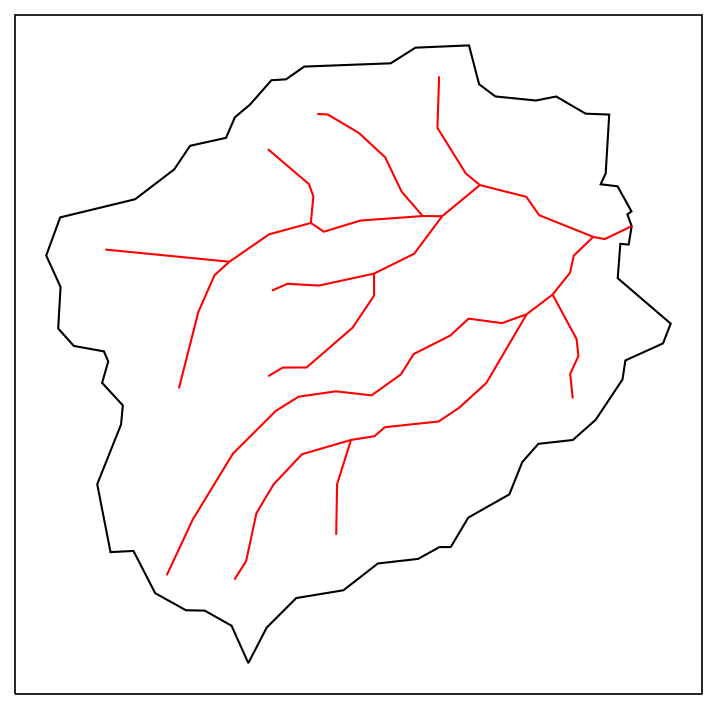

In [7]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

### Generate meshes using river network and watershed shape

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the 
distance from the triangle centroid to the nearest stream.  A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

2021-08-25 17:31:58,512 - root - INFO: 
2021-08-25 17:31:58,513 - root - INFO: Meshing
2021-08-25 17:31:58,514 - root - INFO: ------------------------------
2021-08-25 17:31:58,522 - root - INFO: Triangulating...
2021-08-25 17:31:58,523 - root - INFO:    62 points and 62 facets
2021-08-25 17:31:58,524 - root - INFO:  checking graph consistency
2021-08-25 17:31:58,524 - root - INFO:  tolerance is set to 1
2021-08-25 17:31:58,528 - root - INFO:  building graph data structures
2021-08-25 17:31:58,529 - root - INFO:  triangle.build...
2021-08-25 17:32:02,545 - root - INFO:   ...built: 8086 mesh points and 15945 triangles
2021-08-25 17:32:02,546 - root - INFO: Plotting triangulation diagnostics
2021-08-25 17:32:03,822 - root - INFO:   min area = 289.77447509765625
2021-08-25 17:32:03,823 - root - INFO:   max area = 4979.40869140625


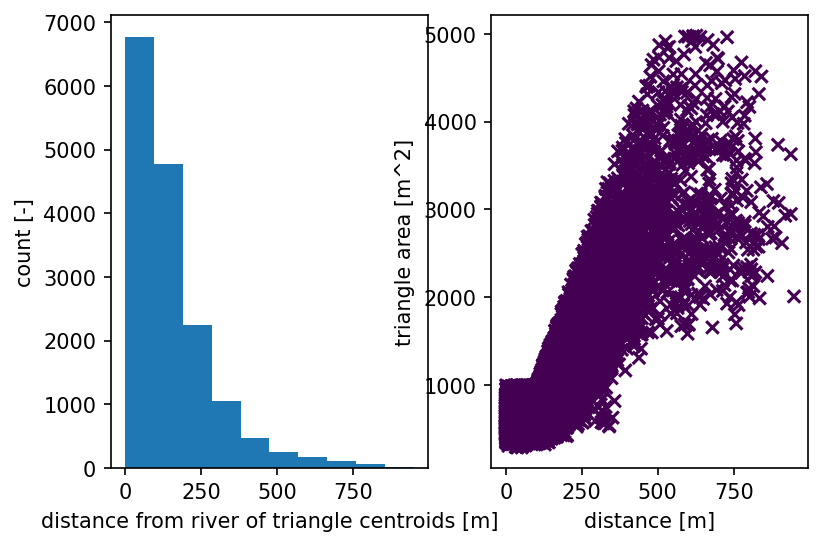

In [8]:
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

### Elevate mesh to DEM

Download a DEM from USGS NED and elevate the triangle nodes to the DEM.

In [9]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2021-08-25 17:32:07,769 - root - INFO: 
2021-08-25 17:32:07,771 - root - INFO: Loading Raster
2021-08-25 17:32:07,771 - root - INFO: ------------------------------
2021-08-25 17:32:07,772 - root - INFO: Collecting raster
2021-08-25 17:32:07,857 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186388, 35.01734099944037, -83.41165773504302, 35.08381933600275]
2021-08-25 17:32:07,859 - root - INFO:   Need:
2021-08-25 17:32:07,860 - root - INFO:     /home/ats_sc_user/short-course/02_model_setup/data/dem/USGS_NED_1as_n36_w084.tif
2021-08-25 17:32:07,861 - root - INFO: source files already exist!
2021-08-25 17:32:07,919 - root - INFO: ... got raster of shape: (239, 276)
2021-08-25 17:32:07,931 - root - INFO: ... got raster bounds: (-83.48845037186388, 35.08381933600275, -83.41178370519467, 35.01743044711165)


In [10]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2021-08-25 17:32:09,432 - root - INFO: 
2021-08-25 17:32:09,434 - root - INFO: Elevating Triangulation to DEM
2021-08-25 17:32:09,434 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

### Plot surface meshes

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

/home/ats_sc_user/watershed-workflow/workflow/plot.py:110: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=window)


[Text(3878000.0, 0, ''),
 Text(3879000.0, 0, ''),
 Text(3880000.0, 0, ''),
 Text(3881000.0, 0, ''),
 Text(3882000.0, 0, ''),
 Text(3883000.0, 0, ''),
 Text(3884000.0, 0, ''),
 Text(3885000.0, 0, '')]

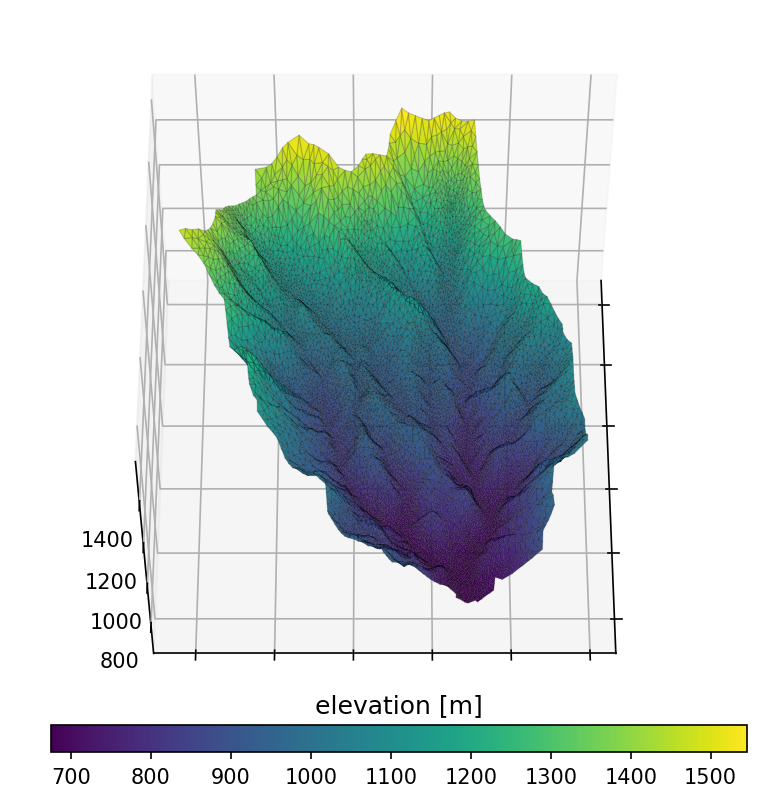

In [11]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

#fig.savefig('watershed_dem_3d')

(273391.62315978657, 279720.38293516275)
(3878583.928534328, 3884209.492779107)


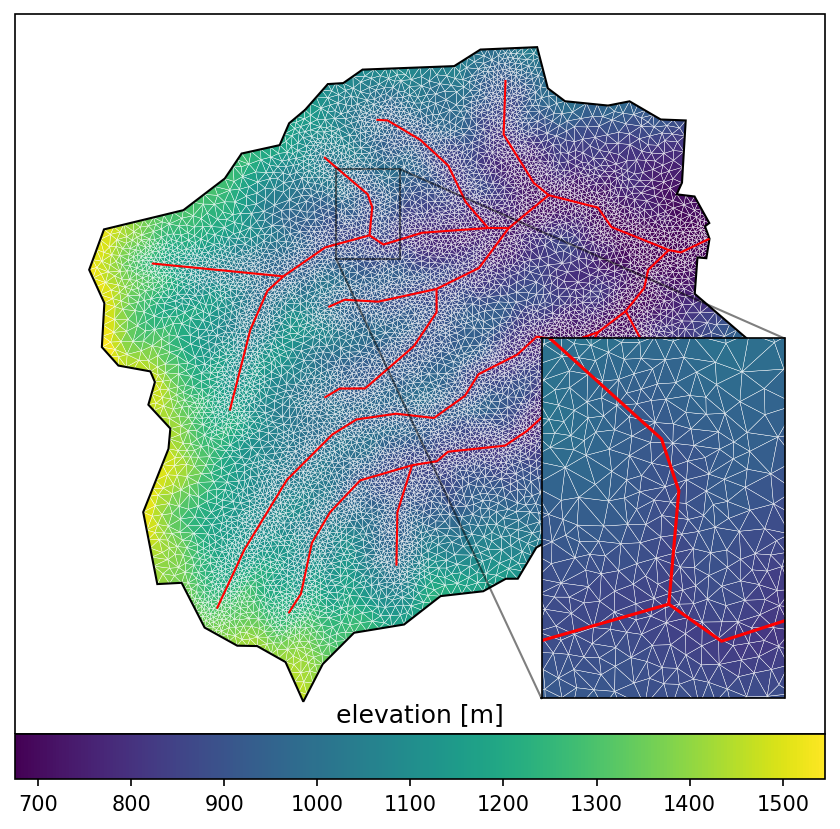

In [12]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')


print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')
fig.savefig('watershed_dem2')

### Construct a 2D mesh

Given the triangle coordinates, we can now construct the 2D mesh object, which stores geometry, topology, and labeled regions.

In [13]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

Conditions a mesh, in place, by removing artificial pits. 

max diff =  6.589355426018074


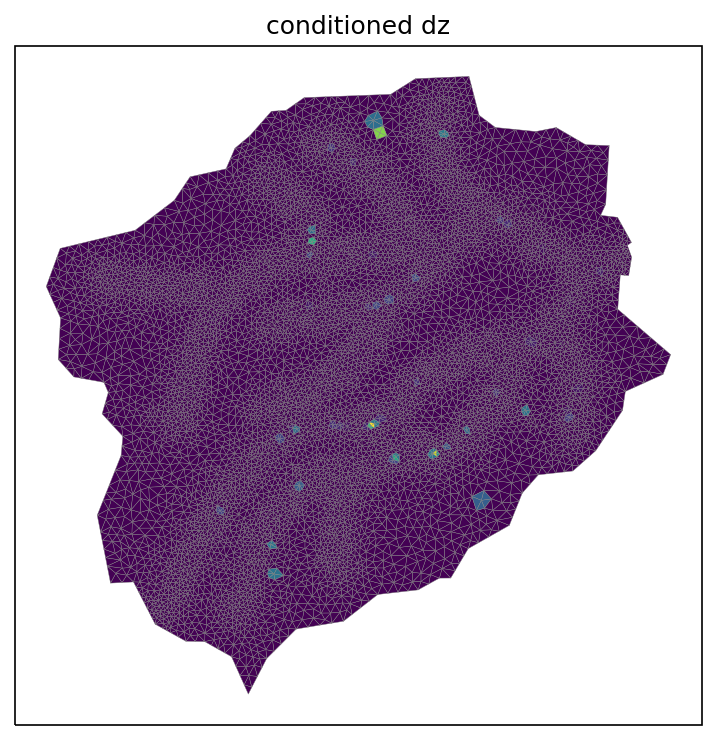

In [14]:
# hydrologically condition the mesh, removing pits
workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

**Note: this will take a while for the ~16 GB land cover file to download!**

In [ ]:
# use pre-downloaded raster
lc_profile, lc_raster = workflow.get_raster_on_shape('./coweeta_data/land_cover/land_cover.tif', 
                                                     watershed.exterior(), crs)

# # download the NLCD raster
# lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
#                                                      watershed.exterior(), crs)

In [20]:
# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))

2021-08-24 16:10:53,343 - root - INFO: 
2021-08-24 16:10:53,344 - root - INFO: Loading Raster
2021-08-24 16:10:53,344 - root - INFO: ------------------------------
2021-08-24 16:10:53,344 - root - INFO: Loading file: '/Users/shua784/github/ats-short-course/02_model_setup/coweeta_data/land_cover/land_cover.tif'
2021-08-24 16:10:53,345 - root - INFO: Collecting raster
2021-08-24 16:10:53,495 - root - INFO: bounds in my_crs: (1129295.2795605154, 1404623.589663599, 1134445.5249579642, 1410000.8473879488)
2021-08-24 16:10:53,496 - root - INFO: ... got raster of shape: (180, 173)
2021-08-24 16:10:53,509 - root - INFO: ... got raster bounds: (1129275.0, 1410015.0, 1134465.0, 1404615.0)
2021-08-24 16:10:53,677 - root - INFO: Found land cover dtypes: uint8
2021-08-24 16:10:53,679 - root - INFO: Found land cover types: {41, 42, 43, 81, 52, 21, 22, 23}


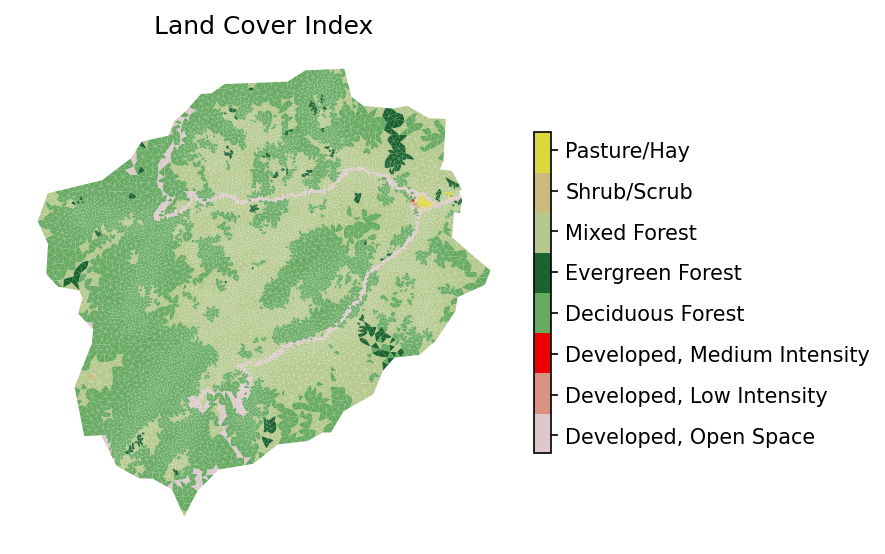

In [19]:
# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

fig, ax = workflow.plot.get_ax(crs)
polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ax.axis('off')
fig.tight_layout()

## Subsurface properties

Get soil and geology structures from SSURGO and GLHYMPS, respectively. Optinally confine the model bottom with depth-to-bedrock.

### SSURGO Soil Properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

In [ ]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], 
                                                                   target_bounds, crs, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

# -- select only those that appear in our color map
soil_survey_props.set_index('mukey', inplace=True, drop=False)
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]

In [22]:
soil_survey_props.head()

residual saturation [-]  Rosetta porosity [-]  \
mukey                                                   
545800                 0.177165              0.431041   
545801                 0.177493              0.432741   
545803                 0.172412              0.400889   
545805                 0.177122              0.388687   
545806                 0.177122              0.388687   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
mukey                                                      
545800                     0.000139             1.470755   
545801                     0.000139             1.469513   
545803                     0.000150             1.491087   
545805                     0.000083             1.468789   
545806                     0.000083             1.468789   

        Rosetta permeability [m^2]   mukey  thickness [cm]  \
mukey                                                        
545800                8.079687e-13  545800           203.0   
545801                8.184952e-13  545801           203.0   
545803                6.477202e-13  545803           203.0   
545805                3.412748e-13  545805           203.0   
545806                3.412748e-13  545806           203.0   

        permeability [m^2]  porosity [-]  bulk density [g/cm^3]  \
mukey                                                             
545800        3.429028e-15      0.307246               1.297356   
545801        3.247236e-15      0.303714               1.292308   
545803        2.800000e-12      0.379163               1.400000   
545805        2.800000e-12      0.384877               1.400000   
545806        2.800000e-12      0.384877               1.400000   

        total sand pct [%]  total silt pct [%]  total clay pct [%] source  
mukey                                                                      
545800           66.356250           19.518750              14.125   NRCS  
545801           66.400000           19.300000              14.300   NRCS  
545803           66.799507           21.700493              11.500   NRCS  
545805           46.721675           41.778325              11.500   NRCS  
545806           46.721675           41.778325              11.500   NRCS

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


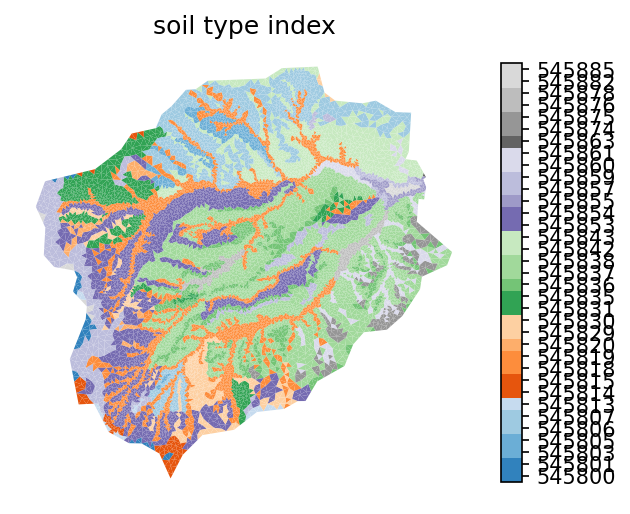

In [23]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = labels) 

ax.set_title('soil type index')
ax.axis('off')
fig.savefig('watershed_soils')



Median soil thickness [-] =  2.03


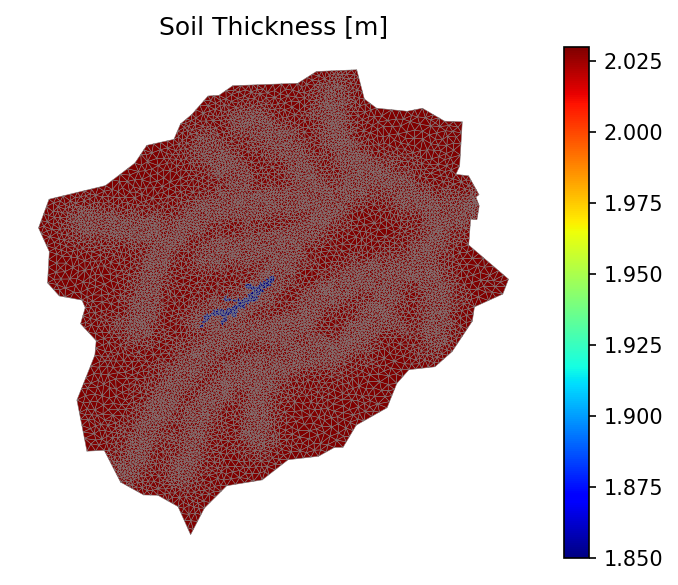

In [24]:
# what does soil thickness look like?
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

iprop = iprop / 100
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('Soil Thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(iprop))
fig.tight_layout()

Median porosity [-] =  0.37152658759508383


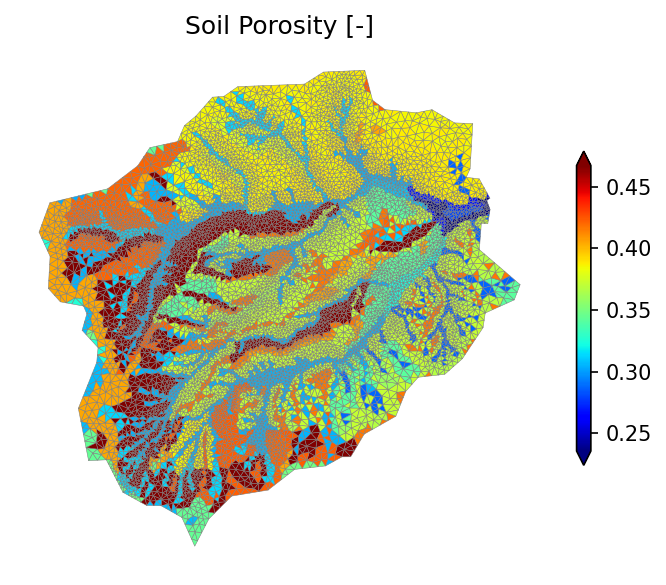

In [25]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('Soil Porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')

print('Median porosity [-] = ', np.nanmedian(iprop))
fig.tight_layout()

Min k [m^2] =  3.2472358738861235e-15


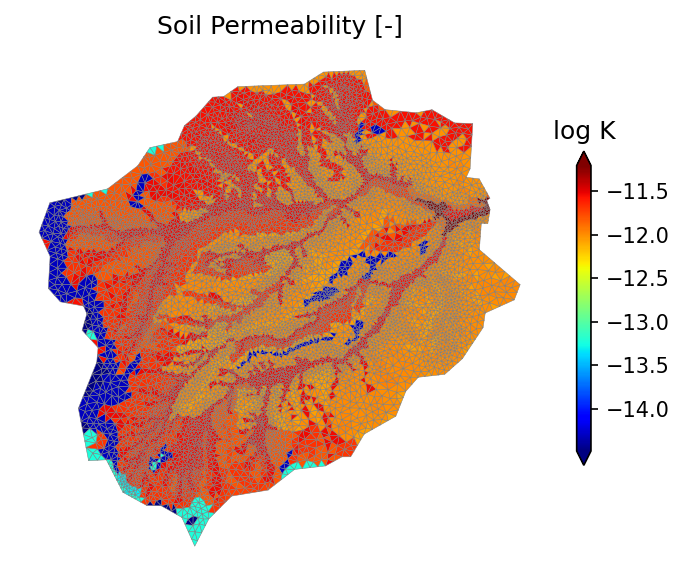

In [26]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('Soil Permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))
fig.tight_layout()

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.

Steps to manually prepare geologic structure:

1. Follow the [link](https://doi.org/10.5683/SP2/TTJNIU) to download `GLHYMPS.zip` (~2.4 GB)
2. Unzip it, and put `GLHYMPS.shp` under `./data/soil_structure/GLHYMPS/`

**Note: need to manually download the GLHYMPS file first before running the following scripts.**

In [17]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

2021-08-25 17:33:48,547 - root - INFO: target bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)


In [ ]:
# use subsetted geologic map
_, geo_survey, geo_survey_props = workflow.get_shapes('./coweeta_data/GLHYMPS/GLHYMPS.shp', 
                                                      target_bounds, 
                                                      crs, crs, properties=True)

# # use the downloaded global product
# _, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], target_bounds, 
#                                                       crs, crs, properties=True)

In [ ]:
# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)

In [34]:
geo_survey_props

id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
0  1793338  GLHYMPS        3.019952e-11            1.61          0.01   

   van Genuchten alpha [Pa^-1]  van Genuchten n [-]  residual saturation [-]  \
0                     0.023953                  2.0                     0.01   

                          description  
0  Colluvial sediments, discontinuous

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


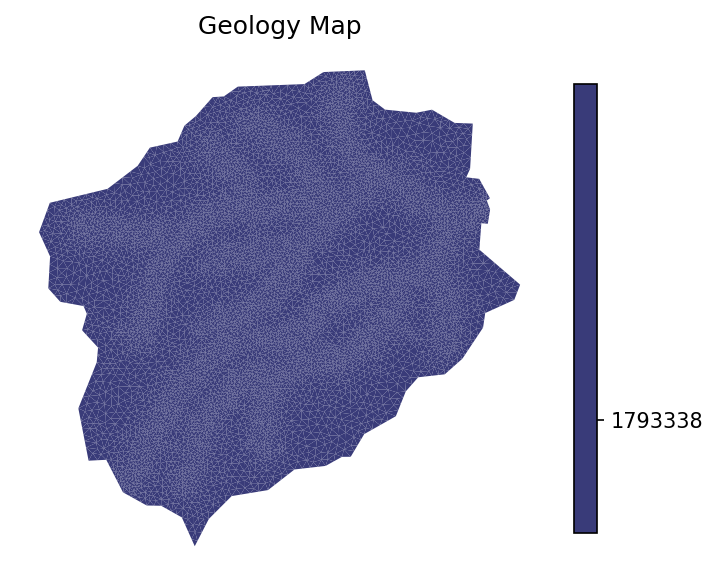

In [35]:
# plot the geologic formation id
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

ax.set_title('Geology Map')
ax.axis('off')
fig.tight_layout()

### Depth-to-bedrock (optional)

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [20]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape('./coweeta_data/DTB/DTB.tif', 
                                                       watershed.exterior(), crs, nodata=-9999)

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)
DTB_mesh = np.where(DTB_mesh >= 0, DTB_mesh, np.nan)

logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2021-08-25 17:34:43,414 - root - INFO: 
2021-08-25 17:34:43,415 - root - INFO: Loading Raster
2021-08-25 17:34:43,415 - root - INFO: ------------------------------
2021-08-25 17:34:43,416 - root - INFO: Loading file: './coweeta_data/DTB/DTB.tif'
2021-08-25 17:34:43,417 - root - INFO: Collecting raster
2021-08-25 17:34:43,569 - root - INFO: ... got raster of shape: (23, 28)
2021-08-25 17:34:43,583 - root - INFO: ... got raster bounds: (-83.47918210999998, 35.074175034, -83.42084878599998, 35.026258375)


bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)


2021-08-25 17:34:44,058 - root - INFO: minimum depth-to-bedrock: 12.72 m
2021-08-25 17:34:44,059 - root - INFO: maximum depth-to-bedrock: 19.68 m


Text(0.5, 1.0, 'DTB [m]')

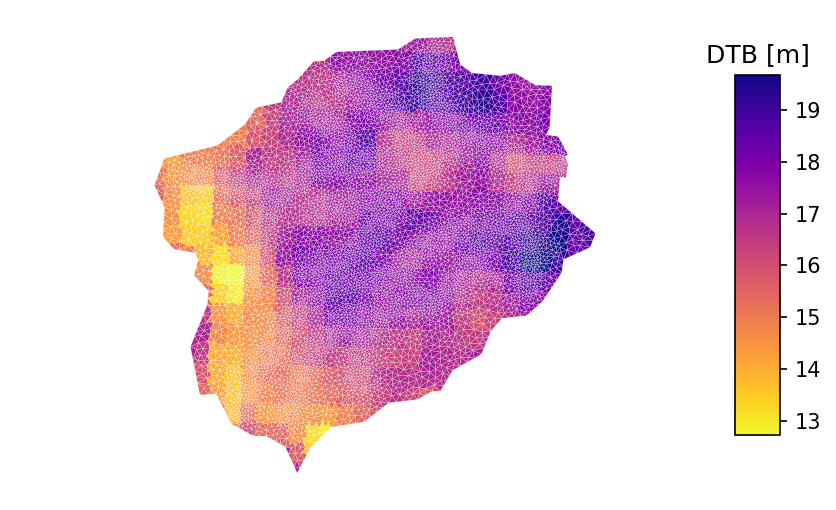

In [21]:
# plot the resulting surface mesh
# ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.8,0.8])
# cbax = fig.add_axes([.8,0.2,0.05,0.6])
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.8,0.8])
cbax = fig.add_axes([.85,0.2,0.05,0.6])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB_mesh, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
# workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')
# fig.tight_layout()


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-998 : geologic layer material IDs
* 999: reserved for bedrock
* 1000-9999 : soil layer material IDs




In [38]:
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

In [39]:
subsurface_props

id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
ats_id                                                                         
100     1793338.0  GLHYMPS        3.019952e-11            1.61      0.010000   
1000          NaN     NRCS        3.429028e-15             NaN      0.307246   
1001          NaN     NRCS        3.247236e-15             NaN      0.303714   
1002          NaN     NRCS        2.800000e-12             NaN      0.379163   
1003          NaN     NRCS        2.800000e-12             NaN      0.384877   
1004          NaN     NRCS        2.800000e-12             NaN      0.384877   
1005          NaN     NRCS        2.800000e-12             NaN      0.384877   
1006          NaN     NRCS        6.219065e-14             NaN      0.349442   
1007          NaN     NRCS        5.999907e-14             NaN      0.344322   
1008          NaN     NRCS        4.813863e-14             NaN      0.314865   
1009          NaN     NRCS        2.912604e-12             NaN      0.305511   
1010          NaN     NRCS        2.906012e-12             NaN      0.313860   
1011          NaN     NRCS        2.912604e-12             NaN      0.305511   
1012          NaN     NRCS        1.867662e-12             NaN      0.423067   
1013          NaN     NRCS        1.586967e-12             NaN      0.423149   
1014          NaN     NRCS        1.568151e-12             NaN      0.421708   
1015          NaN     NRCS        9.308050e-13             NaN      0.378835   
1016          NaN     NRCS        8.624357e-13             NaN      0.417356   
1017          NaN     NRCS        1.020980e-12             NaN      0.371527   
1018          NaN     NRCS        1.032496e-12             NaN      0.341661   
1019          NaN     NRCS        9.952892e-13             NaN      0.386946   
1020          NaN     NRCS        9.952892e-13             NaN      0.387980   
1021          NaN     NRCS        2.078244e-12             NaN      0.466882   
1022          NaN     NRCS        2.103007e-12             NaN      0.467110   
1023          NaN     NRCS        6.238368e-12             NaN      0.235555   
1024          NaN     NRCS        4.981053e-15             NaN      0.405556   
1025          NaN     NRCS        1.308653e-12             NaN      0.268713   
1026          NaN     NRCS        1.079711e-12             NaN      0.288011   
1027          NaN     NRCS        1.968721e-12             NaN      0.309901   
1028          NaN     NRCS        1.515968e-12             NaN      0.263536   
1029          NaN     NRCS        1.004831e-12             NaN      0.366906   
1030          NaN     NRCS        1.116194e-12             NaN      0.360041   
1031          NaN     NRCS        2.800000e-12             NaN      0.324877   
1032          NaN     NRCS        2.282599e-12             NaN      0.364041   
1033          NaN     NRCS        2.894378e-12             NaN      0.280336   
1034          NaN     NRCS        2.800000e-12             NaN      0.326502   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
ats_id                                                     
100                        0.023953             2.000000   
1000                       0.000139             1.470755   
1001                       0.000139             1.469513   
1002                       0.000150             1.491087   
1003                       0.000083             1.468789   
1004                       0.000083             1.468789   
1005                       0.000083             1.468789   
1006                       0.000127             1.445858   
1007                       0.000126             1.444985   
1008                       0.000161             1.496402   
1009                       0.000153             1.480849   
1010                       0.000150             1.470521   
1011                       0.000153             1.480849   
1012                       0.000127             1.404247   
1013          

In [40]:
# save the properties to disk for use in generating input file
subsurface_props.to_csv('watershed_subsurface_properties.csv')

Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [41]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]


In [42]:
# this looks like it would work out:
dzs = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs))

2.0


In [43]:
try:
    total_thickness = np.ceil(DTB_mesh.max())
except:
    total_thickness = 20
logging.info(f'total thickness: {total_thickness} m')

2021-08-24 16:43:54,732 - root - INFO: total thickness: 20.0 m


In [44]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    
# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0
geo_ncells = int(np.ceil((total_thickness- sum(dzs))/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_color)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-08-24 16:43:55,822 - root - INFO: Cell summary:
2021-08-24 16:43:55,823 - root - INFO: ------------------------------------------------------------
2021-08-24 16:43:55,823 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-08-24 16:43:55,824 - root - INFO: ------------------------------------------------------------
2021-08-24 16:43:55,825 - root - INFO:  00 	| 00 	| 545882 	|   0.050000 	|   0.000000
2021-08-24 16:43:55,825 - root - INFO:  01 	| 01 	| 545882 	|   0.050000 	|   0.050000
2021-08-24 16:43:55,825 - root - INFO:  02 	| 02 	| 545882 	|   0.050000 	|   0.100000
2021-08-24 16:43:55,826 - root - INFO:  03 	| 03 	| 545882 	|   0.120000 	|   0.150000
2021-08-24 16:43:55,826 - root - INFO:  04 	| 04 	| 545882 	|   0.230000 	|   0.270000
2021-08-24 16:43:55,827 - root - INFO:  05 	| 05 	| 545882 	|   0.500000 	|   0.500000
2021-08-24 16:43:55,827 - root - INFO:  06 	| 06 	| 545882 	|   0.500000 	|   1.000000
2021-08-24 16:43:55,827 - root - INFO:  07 	| 07 	| 545882 	|   0

**Add bedrock material (optional)**

In [45]:
# get depth of each layer
z_elev = np.cumsum(np.array([0] + dzs + [dz]*geo_ncells))
z_center = z_elev[:-1] + (z_elev[1:] - z_elev[:-1])/2

mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB_mesh[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

**extrude to 3D mesh**

In [46]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

**add land cover types**

In [47]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [48]:
# save to disk
try:
    os.remove('coweeta_mesh.exo')
except FileNotFoundError:
    pass
m3.write_exodus('coweeta_mesh.exo')


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: coweeta_mesh.exo
Closing exodus file: coweeta_mesh.exo
